In [1]:
import diffusion

import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

%matplotlib inline

# Cross sections, core buckling and diffusion length

In [31]:
D_c = 1.3
Sigma_a_c = 0.5
nuSigma_f_c = 0.9
D_R = 1.5
Sigma_a_R = 0.1

# calculate core buckling assuming critical
k = 1.0
B2_c = (1.0/k*nuSigma_f_c - Sigma_a_c) / D_c
B_c = np.sqrt(B2_c)

# calculate diffusion length in reflector
L_R = np.sqrt(D_R/Sigma_a_R)

# Bare core size
a_bare = np.pi / np.sqrt(B2_c)
print a_bare

5.66358669957


# Verify bare core k is one

In [32]:
# create fuel material
fuel = diffusion.Material(num_energy_groups=1)

fuel.diffusion = [1.3]
fuel.total = [0.5]
fuel.scattering = [[0.0]]
fuel.nu_fission = [0.9]
fuel.chi = [1.0]

# put fuel in materials object
materials = diffusion.Materials(num_materials=1, num_energy_groups=1)
materials.set_material(fuel, 0)

# create geometry and mesh
mesh = diffusion.Mesh(num_parts=1)
mesh.material_map = [0]
mesh.part_sizes = [a_bare]
mesh.part_mesh = [2000]
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

# create solver and solve the eigenvalue problem
solver = diffusion.Solver(materials, mesh)
solver.solve()

# extract the eigenmodes
eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()
print eigs[0]

1.00000009139


# Find Reflected Core Length

In [33]:
## Define buckling equation function from notes in residual form

In [34]:
def F(x):
    residual = D_c*B_c*np.tan(B_c/2.0 * x) - D_R/L_R
    return residual

## Plot residual

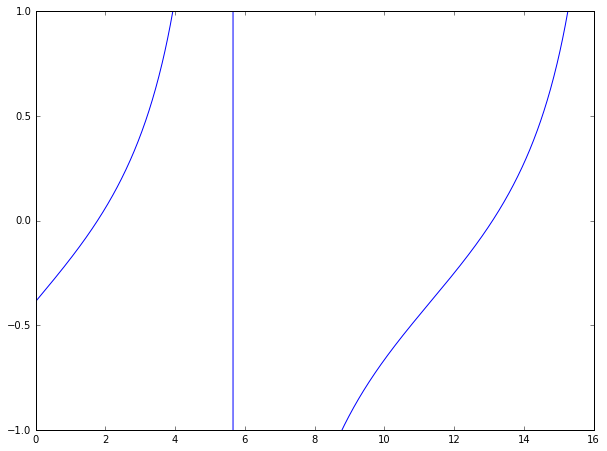

In [35]:
# Plot from 0 to 5pi
x_range = np.arange(0, 5*np.pi, 5*np.pi/1000.0)

fig, ax = plt.subplots(figsize=(10, 7.5))
ax.set_ylim(-1.0, 1.0)
ax.plot(x_range, F(x_range))

## Use optimization algorithm to find zero of function

In [36]:
a_reflected = scipy.optimize.broyden1(F, [0.1], f_tol=1e-14)
print a_reflected

[ 1.77708435]


## Verify critical dimension with reflector

In [37]:
# create reflector material
refl = diffusion.Material(num_energy_groups=1)

refl.diffusion = [1.5]
refl.total = [0.1]
refl.scattering = [[0.0]]
refl.nu_fission = [0.0]
refl.chi = [0.0]

# create materials object with fuel and reflector
materials = diffusion.Materials(num_materials=2, num_energy_groups=1)
materials.set_material(fuel, 0)
materials.set_material(refl, 1)

# create geometry and mesh
mesh = diffusion.Mesh(num_parts=3)
mesh.material_map = [1, 0, 1]
mesh.part_sizes = [100.0, a_reflected, 100.0]
mesh.part_mesh = [1000, 2000, 1000]
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

# create solver and solve
solver = diffusion.Solver(materials, mesh)
solver.solve()

# extract eigemodes
eigs = solver.extract_eigenvalues()
slab_x_refl, fluxes_refl = solver.extract_eigenvectors()
print eigs[0]

1.00003395603


(-20, 20)

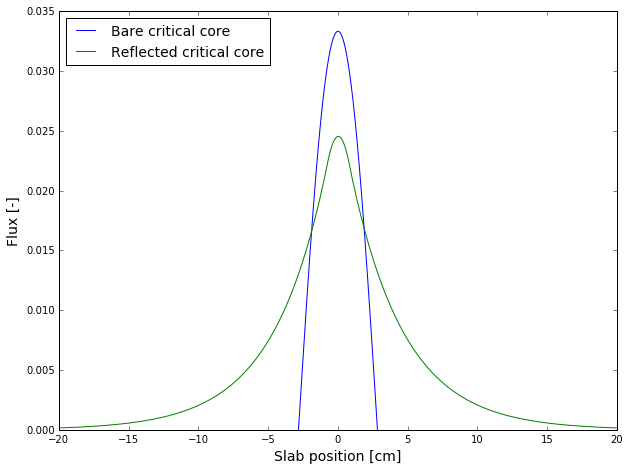

In [45]:
fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(slab_x-slab_x[-1]/2, fluxes[0,:,0], label="Bare critical core")
ax.plot(slab_x_refl-slab_x_refl[-1]/2, fluxes_refl[0,:,0], label="Reflected critical core")
ax.set_xlabel("Slab position [cm]", fontsize=14)
ax.set_ylabel("Flux [-]", fontsize=14)
ax.legend(fontsize=14, loc=2)
ax.set_xlim(-20, 20)

## Reflector Savings

In [46]:
# For a slab usually quoted for one side
savings = a_bare/2.0 - a_reflected/2.0

print savings

[ 1.94325117]
